<a href="https://colab.research.google.com/github/tainangao/CNN-X-Ray-Image-classification/blob/master/WEEK_4_chest_xray_pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = 'tainangao'
os.environ['KAGGLE_KEY'] = '652178c9154b6ae494fd27a5dc17f549'

In [2]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 1.14G/1.15G [00:13<00:00, 68.8MB/s]
100% 1.15G/1.15G [00:13<00:00, 92.3MB/s]


In [0]:
!unzip chest-xray-pneumonia.zip
!unzip chest_xray.zip

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [0]:
training_dir = './chest_xray/train'
validation_dir = './chest_xray/test'
test_dir = './chest_xray/val'

In [0]:
train_path = 'chest_xray/train'
valid_path = 'chest_xray/val'
test_path = 'chest_xray/test'

In [8]:
print(len(train_path))
print(len(valid_path))
print(len(test_path))

16
14
15


In [9]:
# ImageDataGenerator() >> a keras object, generates batches of tensor image data
# flow_from_directory >> take the path to the directory and generalize batched of normalized data

train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(299, 299), classes=['NORMAL', 'PNEUMONIA'], batch_size=32)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(299, 299), classes=['NORMAL', 'PNEUMONIA'], batch_size=4)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(299, 299), classes=['NORMAL', 'PNEUMONIA'], batch_size=16)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


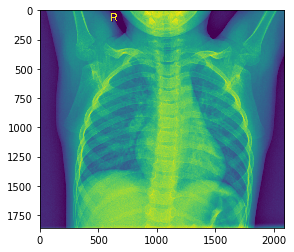

In [10]:
img = mpimg.imread(training_dir + '/NORMAL/IM-0115-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

In [0]:
def plot_images(path, labeled=False, max_images=6):
  amount = 0
  fig = plt.figure(figsize=(12, 6))

  for file in os.listdir(path):
    if file.endswith('.jpeg'):
      if amount == max_images:
        break

      img = mpimg.imread(os.path.join(path, file))
      plt.subplot(231+amount)
      if labeled:
        plt.title(file.split('_')[1])
      imgplot = plt.imshow(img)

      amount += 1

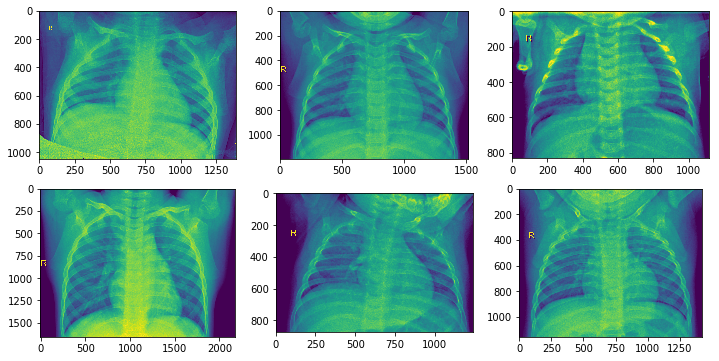

In [12]:
plot_images(training_dir + '/NORMAL')

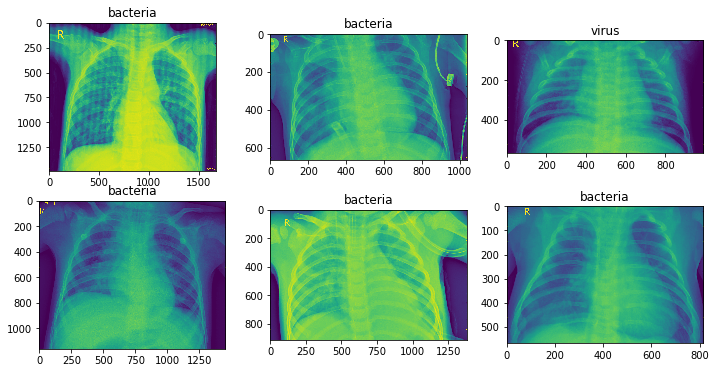

In [13]:
plot_images(training_dir + '/PNEUMONIA', labeled=True)

# Build and train CNN

In [0]:
from keras.applications.inception_v3 import InceptionV3

In [0]:
def get_model():
  base_model = InceptionV3(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dense(1024, activation='relu')(x)
  x = keras.layers.BatchNormalization()(x)
  predictions = keras.layers.Dense(2, activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = False
  
  model.summary()
  return model

In [0]:
model = get_model()

## Train the fine-tuned InceptionV3 model

In [0]:
model.compile(keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
model.fit_generator(train_batches, steps_per_epoch=4, 
                    validation_data=valid_batches, validation_steps=4, epochs=5, verbose=2)

Epoch 1/5
 - 47s - loss: 0.5728 - acc: 0.8047 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/5
 - 41s - loss: 0.8240 - acc: 0.8125 - val_loss: 5.3156 - val_acc: 0.6250
Epoch 3/5
 - 40s - loss: 0.7299 - acc: 0.7891 - val_loss: 6.2854 - val_acc: 0.5625
Epoch 4/5
 - 40s - loss: 0.5655 - acc: 0.8594 - val_loss: 6.8513 - val_acc: 0.5625
Epoch 5/5
 - 40s - loss: 0.6827 - acc: 0.8438 - val_loss: 6.0443 - val_acc: 0.6250


## Predict using fine-tuned InceptionV3 model

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
test_imgs, test_labels = next(test_batches)

In [30]:
test_labels = test_labels[:,0]
test_labels

array([1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1.],
      dtype=float32)

In [0]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)

In [0]:
cm = confusion_matrix(test_labels, np.round(predictions[:,0]))

Confusion matrix, without normalization
[[10  0]
 [ 6  0]]


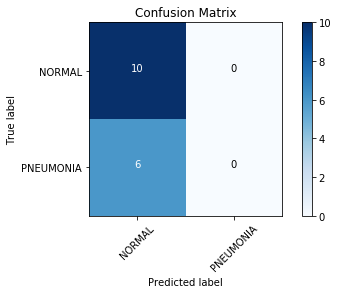

In [35]:
cm_plot_labels = ['NORMAL','PNEUMONIA']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

## Model saving and loading

In [0]:
model.save('pheumonia_model.h5')

In [0]:
new_model = keras.models.load_model('pheumonia_model.h5')